**Computer Vision (AIRO) Project 4 SESSION 2**\
Car Plate Recognition and Reconstruction with Deep Learning\
**YOLO v8**\
This notebook shows how to use the YOLOv8 object detection model to build a car license plate detection system.  The process consists of:



*   Preparing the dataset of pictures of cars with license plates annotated.
*   Preparing the dataset to fit with the yolo structure to work with the dataset.
*   use the dataset to train the YOLOv8 model.
*   Performing inference on test images to detect license plates.
*   displaying the results of the detection.

**NOTE:**


*   Although the paper have used the YOLOv5 for license plate detection , In this notebook, we have used the YOLOv8 for its better accuracy, newest improved performance and features.
*   The first Run of this project has lead to a crash of the computer due to the disq usage. This crash has occuried in the training process of the second epoch. So that why in this notebook, you will see screenshots already tooked before the crash.









1. **Includes and utils utils**

In [ ]:
import os
import torch
import random
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision
from torchvision import transforms
import pandas as pd
import cv2
import shutil

**DataSet setup**\
Import the dataset from kaggle CCPD(Chinese city parking dataset), visuilization of some samples. It contain 199 996 real images of cars showing their plates.

In [ ]:
import kagglehub

# here we Download the dataset (it xan be exported from google drive if it was downloaded there)
path = kagglehub.dataset_download("binh234/ccpd-preprocess")

print("Path to dataset files:", path)

100%|██████████| 18.5G/18.5G [03:14<00:00, 102MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/binh234/ccpd-preprocess/versions/2


In [ ]:
dataset_path=path+'/CCPD2019/ccpd_base/'
print(dataset_path)


/root/.cache/kagglehub/datasets/binh234/ccpd-preprocess/versions/2/CCPD2019/ccpd_base/


Image: 0307770593869-86_94-249,546_524,669-530,633_257,670_255,563_528,526-0_0_0_14_33_26_33-146-43.jpg
Image: 00646551724138-89_88-232,435_370,488-372,487_232,489_227,439_367,437-0_0_18_17_29_30_30-110-30.jpg
Image: 0147641283524-91_80-187,562_416,640-422,646_192,636_173,560_403,570-0_0_27_29_28_27_33-97-16.jpg
Image: 0123970306514-90_91-312,454_487,531-493,524_317,528_322,458_498,454-0_0_21_1_30_32_28-146-11.jpg
Image: 00818965517241-90_92-402,376_564,443-569,437_404,436_405,378_570,379-0_0_11_24_32_30_8-43-12.jpg
Image: 0226293103448-90_93-242,303_535,408-530,389_237,407_236,305_529,287-0_0_5_29_30_33_23-149-56.jpg
Image: 022030651341-99_75-281,439_495,560-497,558_278,513_273,434_492,479-0_0_31_30_24_12_33-96-50.jpg



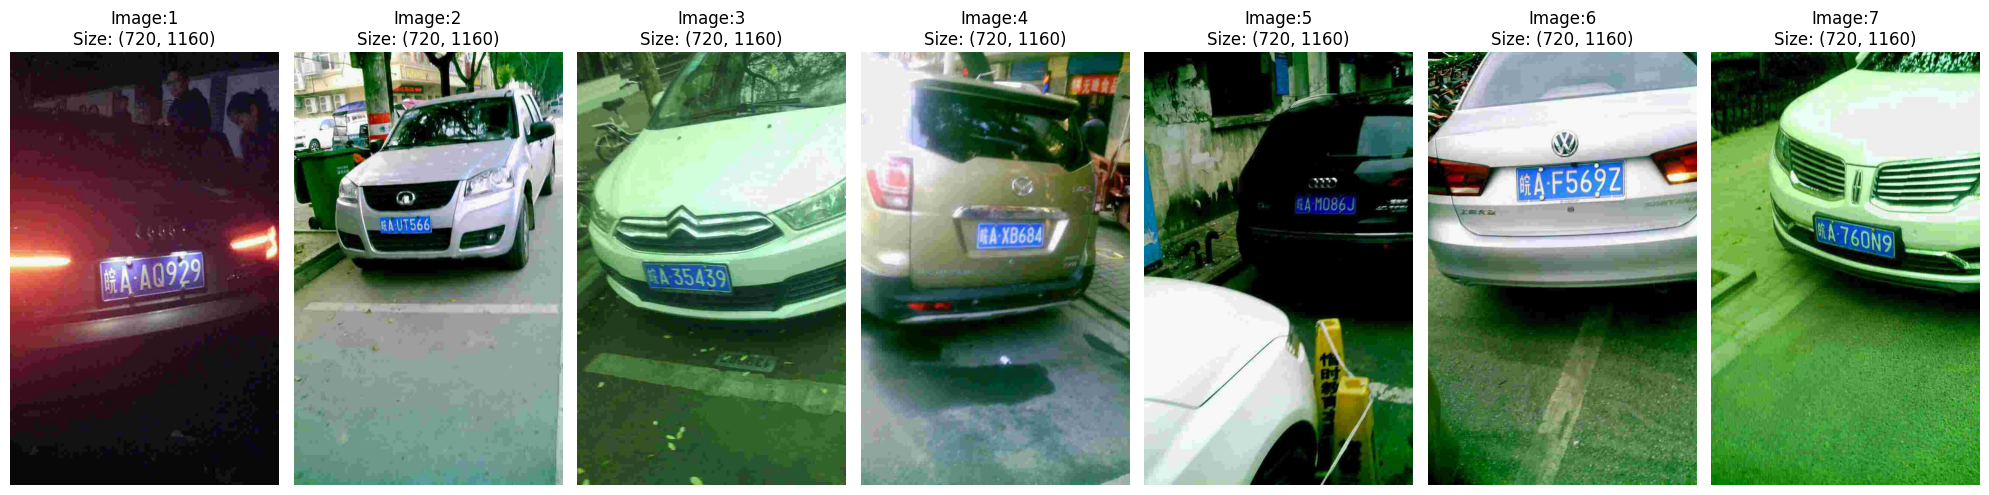

In [ ]:
#visuilization some samples
def sample_images(dataset_path,num_of_images):
  image_files = random.sample([img for img in os.listdir(dataset_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))],num_of_images)
  plt.figure(figsize=(20, 6))

  for idx, img_file in enumerate(image_files):
      img_path = os.path.join(dataset_path, img_file)
      try:
            image = Image.open(img_path).convert("RGB")
            print(f"Image: {img_file}")
            plt.subplot(1, num_of_images, idx + 1)
            plt.imshow(image)
            plt.title(f"Image:{idx+1}\nSize: {image.size}")
            plt.axis("off")
      except Exception as e:
            print(f"Error{img_file}: {e}")
  print('')
  plt.tight_layout()
  plt.show()
sample_images(dataset_path,num_of_images=7)

In [ ]:
#to extract the bonding boxe and the other from the image name
class CCPD_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.dataset_path, img_name)
        baseimg = Image.open(img_path)
        orig_w, orig_h = baseimg.size

        if self.transform:
            image = self.transform(baseimg.convert("RGB"))
        else:
            image = baseimg.convert("RGB")

        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))

        x_center = (x1 + x2) / 2 / orig_w
        y_center = (y1 + y2) / 2 / orig_h
        width = (x2 - x1) / orig_w
        height = (y2 - y1) / orig_h

        class_id = 0

       #used later on for the recognition part
        province_to_all_idx = {i: i for i in range(35)}
        alphabet_to_all_idx = {i: i for i in range(26)}
        ads_to_all_idx = {i: i for i in range(36)}

        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx.get(charaslist[0], 0)
        alphabetcharidx = alphabet_to_all_idx.get(charaslist[1], 0)
        adscharidx = []
        for idx in charaslist[2:]:
            adscharidx.append(ads_to_all_idx.get(idx, 0))
        charaslistdef = [provincecharidx, alphabetcharidx] + adscharidx

        return img_name, (class_id, x_center, y_center, width, height)

**MODEL SETUP**\
This part begins by organizing the dataset and dividing it into test, validation, and training sets. Then iy perform label changes to txt. Following that, the data is organized in accordance with the YOLOv8 standard, which includes generating a matching.yaml configuration file. Using the Ultralytics framework to train the model requires this YAML file, which also specifies the class names and dataset directories.


In [ ]:
# !pip install ultralytics
# NOTE THAT it may be already installed ultralytics

import ultralytics
ultralytics.checks() # This verifies your setup, including CUDA

Ultralytics 8.3.161 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Setup complete ✅ (16 CPUs, 7.7 GB RAM, 119.7/1006.9 GB disk)


Due to the crach we was urged to re run the code again however this part was saved earlier and this is the output obtained by it. So all dataset are set in the way te be fed for the yolo model.

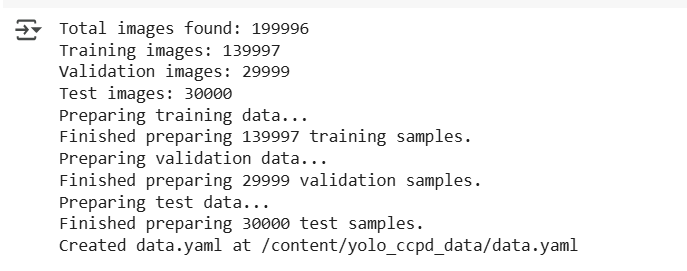

In [ ]:
def prepare_yolo_dataset(ccpd_dataset_path, output_root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Ensure ratios sum to 1
    if not (train_ratio + val_ratio + test_ratio == 1.0):
        print("the sum is not equal to 1 to solve it i have changed the test ratio")
        test_ratio = 1.0 - train_ratio - val_ratio
        if test_ratio < 0:
            raise ValueError("Invalid ratios: train_ratio + val_ratio is greater than 1.")
        print(f"Adjusted ratios: Train={train_ratio}, Val={val_ratio}, Test={test_ratio}")

    # Create necessary directories used by yolo for images and labels
    # based on a specific architecture specified by the yolo
    train_img_dir = os.path.join(output_root_dir, 'images', 'train')
    train_lbl_dir = os.path.join(output_root_dir, 'labels', 'train')
    val_img_dir = os.path.join(output_root_dir, 'images', 'val')
    val_lbl_dir = os.path.join(output_root_dir, 'labels', 'val')
    test_img_dir = os.path.join(output_root_dir, 'images', 'test')
    test_lbl_dir = os.path.join(output_root_dir, 'labels', 'test')

    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_lbl_dir, exist_ok=True)
    os.makedirs(val_img_dir, exist_ok=True)
    os.makedirs(val_lbl_dir, exist_ok=True)
    os.makedirs(test_img_dir, exist_ok=True)
    os.makedirs(test_lbl_dir, exist_ok=True)

    # extract all the images and shuffle them (HERE WE CAN ADD SOME ROTATION/ TRANSFORMATION FOR THE IMAGES)
    all_image_files = [f for f in os.listdir(ccpd_dataset_path) if f.endswith('.jpg')]
    random.shuffle(all_image_files) # Shuffle for random split

    total_images = len(all_image_files)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    # Test size gets the rest to account for potential rounding
    test_size = total_images - train_size - val_size

    train_files = all_image_files[:train_size]
    val_files = all_image_files[train_size : train_size + val_size]
    test_files = all_image_files[train_size + val_size : ]

    print(f"Total images found: {total_images}")
    print(f"Training images: {len(train_files)}")
    print(f"Validation images: {len(val_files)}")
    print(f"Test images: {len(test_files)}")

    # Use the CCPD_Dataset to parse and generate labels
    temp_dataset = CCPD_Dataset(ccpd_dataset_path, all_image_files)

    # FUNCTION TO TRANSFORM THE DATASET LABES TO A SPECIFIC FORMAT LIKE TXT
    def process_split(files, img_output_dir, lbl_output_dir):
        count = 0
        for img_name in files:
            idx = temp_dataset.image_files.index(img_name)
            _, (class_id, x_center, y_center, width, height) = temp_dataset[idx]

            shutil.copy(os.path.join(ccpd_dataset_path, img_name), os.path.join(img_output_dir, img_name))

            label_filename = img_name.replace(".jpg", ".txt")
            with open(os.path.join(lbl_output_dir, label_filename), 'w') as f:
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
            count += 1
        return count

    print("Preparing training data...")
    processed_train = process_split(train_files, train_img_dir, train_lbl_dir)
    print(f"Finished preparing {processed_train} training samples.")

    print("Preparing validation data...")
    processed_val = process_split(val_files, val_img_dir, val_lbl_dir)
    print(f"Finished preparing {processed_val} validation samples.")

    print("Preparing test data...")
    processed_test = process_split(test_files, test_img_dir, test_lbl_dir)
    print(f"Finished preparing {processed_test} test samples.")

       # Create data.yaml file, which is used by the yolo to perform the training
    data_yaml_path = os.path.join(output_root_dir, 'data.yaml')
    data_yaml_content = f"""
path: {os.path.abspath(output_root_dir)}
train: images/train
val: images/val
test: images/test
nc: 1
names: ['car_plate']
"""
    with open(data_yaml_path, 'w') as f:
        f.write(data_yaml_content)
    print(f"Created data.yaml at {data_yaml_path}")



#here you should change the dataset path based on the one used in the computer/ colab
dataset_path = dataset_path
output_yolo_dir = '/home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data' # Output directory for YOLO formatted data

if not os.path.exists(dataset_path):
    print(f"Error: Original CCPD dataset path not found: {dataset_path}")
    print("Please check your Google Drive mount and the exact path to your CCPD dataset folder.")
else:
    prepare_yolo_dataset(dataset_path, output_yolo_dir)



Total images found: 199996
Training images: 139997
Validation images: 29999
Test images: 30000
Preparing training data...


KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Due to a crash of the laptop (due to disq usage problems) we have finished the training of the first epoch however in the second epoch we have suffered from the crash. So when we have rerun again the code, we have directly later on used the yolo trained from the first epoch since our leptop have suffered from the CRASH. here in this notebook can see the we have directly interupt the run however it has finished before the crach 1 epochs which has lead to this output
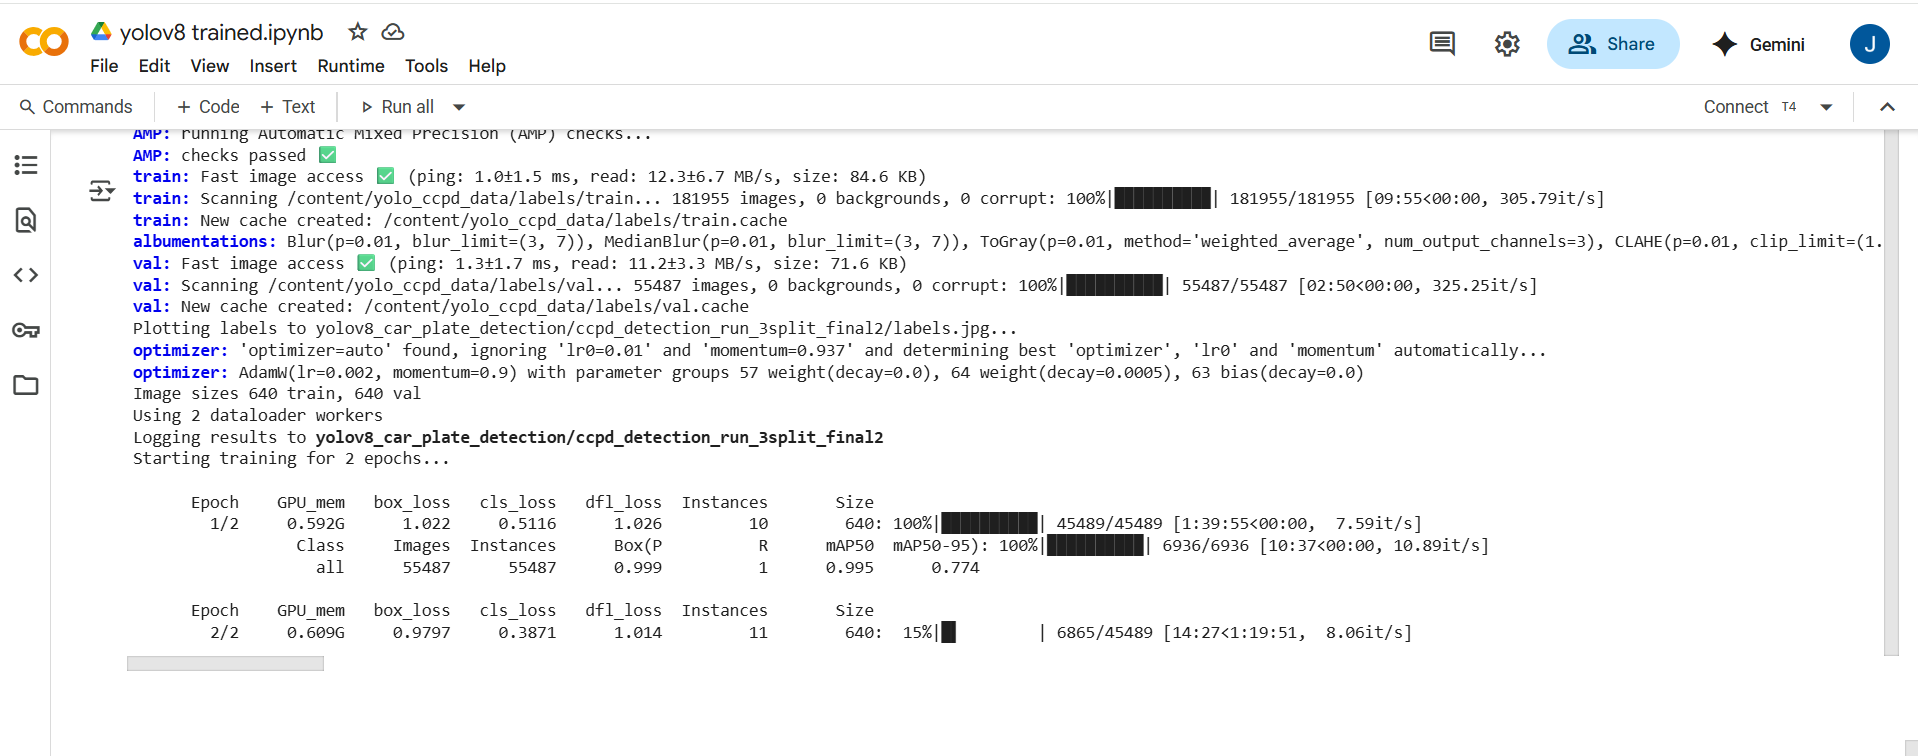

In [ ]:
# now let's train the yolo model
print("--- Step 5: Training the YOLOv8 Model ---")

# Load a pre-trained YOLOv8n model (nano version, good starting point)
model = YOLO('yolov8n.pt')

# Training parameters
num_epochs = 2       # Number of training epochs. set to 2 for computational purposes
batch_size = 4       # Number of images per batch. also set to 4 due to computational purposes.
img_size = 640
device = 'cuda' if torch.cuda.is_available() else 'cpu' # remake sure of the use of the gpu

# set names for the project
project_name = 'yolov8_car_plate_detection'
run_name = 'ccpd_detection_run_3split_final'

print(f"Training on device: {device}")
print(f"Input image size: {img_size}x{img_size}")
print(f"Training run name: {run_name} under project: {project_name}")

results = model.train(data=os.path.join(output_yolo_dir, "data.yaml"),
                      epochs=num_epochs,
                      batch=batch_size,
                      imgsz=img_size,
                      device=device,
                      name=run_name,
                      project=project_name,
                      val=True) # Enables validation during training

print("DONE")


--- Step 5: Training the YOLOv8 Model ---
Training on device: cuda
Input image size: 640x640
Training run name: ccpd_detection_run_3split_final under project: yolov8_car_plate_detection
New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.161 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7,

train: Scanning /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/labels/train... 142802 images, 0 backgrounds, 0 corrupt: 100%|██████████| 142802/142802 [02:19<00:00, 1023.87it/s]


train: New cache created: /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/labels/train.cache
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 118.9±83.4 MB/s, size: 66.3 KB)


val: Scanning /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/labels/val.cache... 29999 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29999/29999 [00:00<?, ?it/s]


Plotting labels to yolov8_car_plate_detection/ccpd_detection_run_3split_final2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8_car_plate_detection/ccpd_detection_run_3split_final2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2     0.547G      1.304      3.945      1.345          6        640:   0%|          | 93/35701 [00:12<1:22:36,  7.18it/s]


KeyboardInterrupt: 

In this step, we use TensorBoard to monitor and visualize the model’s training progress. While the notebook itself does not generate static plots due to the CRASH since it does not contain many epochs

In [ ]:
print("Step 6: Monitoring Training with TensorBoard")
%load_ext tensorboard
%tensorboard --logdir {project_name}
print("TensorBoard launched. Check the output above for the link.")


--- Step 6: Monitoring Training with TensorBoard ---
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


TensorBoard launched. Check the output above for the link.


**Model Evaluation on Test Dataset**
After training is complete, we evaluate the performance of the trained YOLOv8 model on a separate test dataset to see its performance. Then there is a visuilization of the result on the test dataset. Draw the predicted bonding box of the plate

In [ ]:

# perform the Trained Model on the Separate Test DataSet

print("Evaluating Model on Test DataSet ")

best_model_path = os.path.join('/home/dalex/AIRO_2024-2025/Computer_Vision/SSD_MobileNetV3_LicensePlateRecognition/yolov8_car_plate_detection', run_name, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    trained_model = YOLO(best_model_path)
    print(f"Loading best model from: {best_model_path}")

    metrics = trained_model.val(data=os.path.join(output_yolo_dir, "data.yaml"), split='test')

    print("\n--- Test Set Evaluation Metrics ---")
    print(f"mAP50-95 (Test): {metrics.box.map}")
    print(f"mAP50 (Test): {metrics.box.map50}")
    print(f"Precision (Test): {metrics.box.mp}")
    print(f"Recall (Test): {metrics.box.mr}")
    print("-----------------------------------")
else:
    print(f"Error: Best model not found at {best_model_path}. Cannot evaluate on test set.")
print("Test set evaluation complete.")


--- Step 8: Evaluating Model on Test Set ---
Loading best model from: /home/dalex/AIRO_2024-2025/Computer_Vision/SSD_MobileNetV3_LicensePlateRecognition/yolov8_car_plate_detection/ccpd_detection_run_3split_final/weights/best.pt
Ultralytics 8.3.161 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 148.8±42.5 MB/s, size: 89.3 KB)


val: Scanning /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/labels/test... 30000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30000/30000 [00:29<00:00, 1009.85it/s]


val: New cache created: /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1875/1875 [03:21<00:00,  9.30it/s]


                   all      30000      30000      0.999          1      0.995      0.774
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val

--- Test Set Evaluation Metrics ---
mAP50-95 (Test): 0.7744796312972488
mAP50 (Test): 0.9949211578321261
Precision (Test): 0.9993336989783614
Recall (Test): 0.9999666666666667
-----------------------------------
Test set evaluation complete.



--- Step 9: Visualizing Predicted Bounding Boxes ---
Visualizing detections on 5 random test images...

Processing image: 00738026819924-90_90-152,336_299,388-307,402_141,393_141,330_307,339-0_0_3_26_23_30_30-107-12.jpg

image 1/1 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/00738026819924-90_90-152,336_299,388-307,402_141,393_141,330_307,339-0_0_3_26_23_30_30-107-12.jpg: 640x416 1 car_plate, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 416)


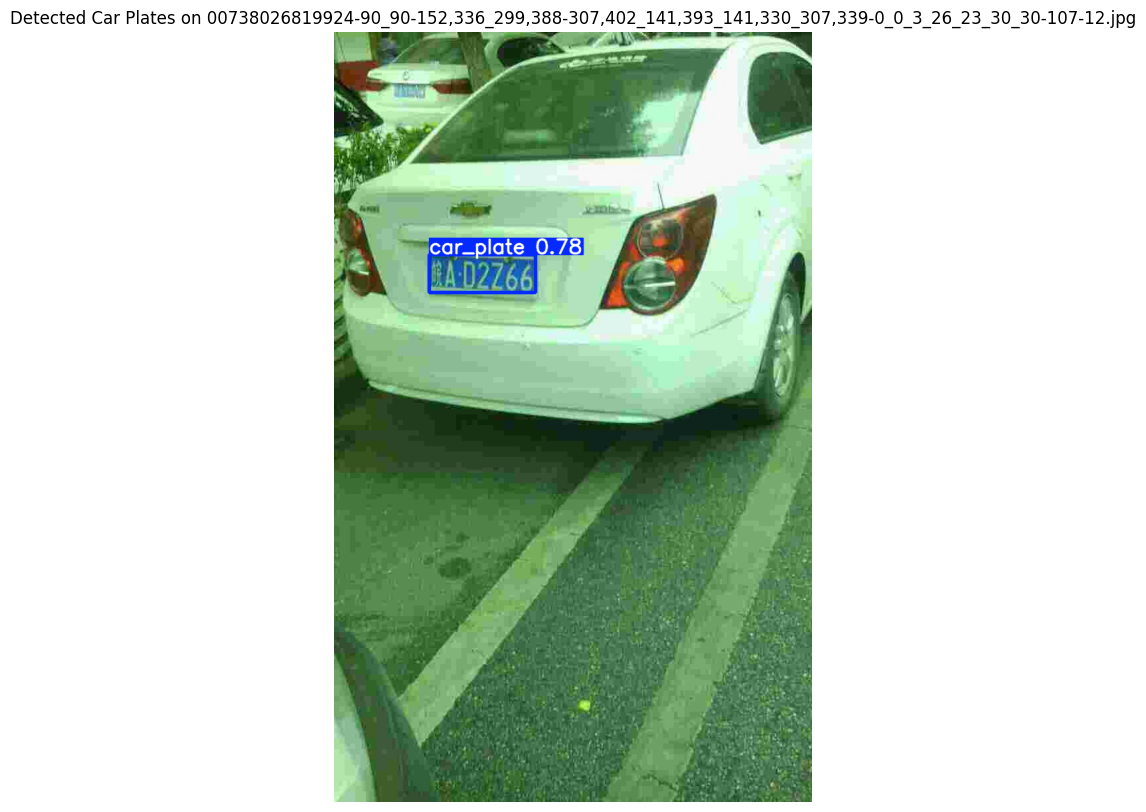

  Detections for 00738026819924-90_90-152,336_299,388-307,402_141,393_141,330_307,339-0_0_3_26_23_30_30-107-12.jpg:
    - car_plate, Confidence: 0.78, Box: [143, 335, 303, 392]

Processing image: 027658045977-91_88-175,313_488,422-499,416_177,410_183,297_505,303-0_0_16_31_7_31_27-53-41.jpg

image 1/1 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/027658045977-91_88-175,313_488,422-499,416_177,410_183,297_505,303-0_0_16_31_7_31_27-53-41.jpg: 640x416 1 car_plate, 9.0ms
Speed: 1.4ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 416)


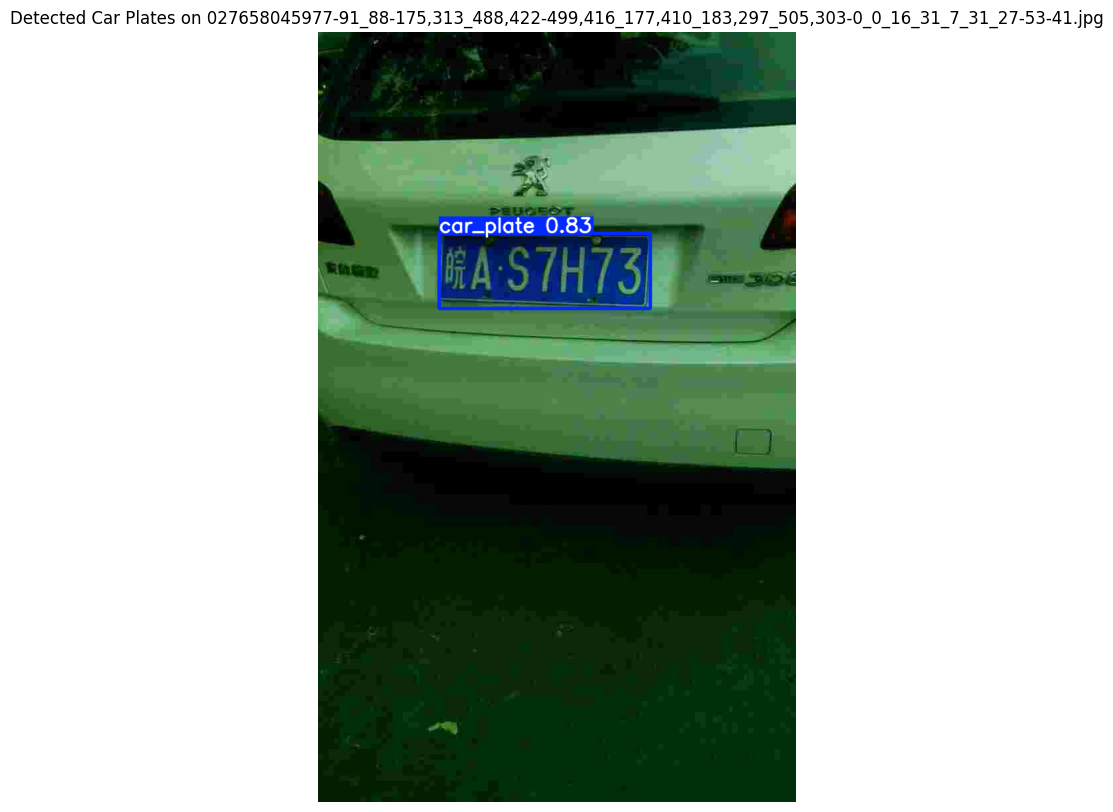

  Detections for 027658045977-91_88-175,313_488,422-499,416_177,410_183,297_505,303-0_0_16_31_7_31_27-53-41.jpg:
    - car_plate, Confidence: 0.83, Box: [182, 303, 500, 416]

Processing image: 00763290229885-91_94-291,511_431,567-428,567_283,572_293,511_438,506-0_0_5_3_29_32_24-127-7.jpg

image 1/1 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/00763290229885-91_94-291,511_431,567-428,567_283,572_293,511_438,506-0_0_5_3_29_32_24-127-7.jpg: 640x416 1 car_plate, 8.7ms
Speed: 1.5ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 416)


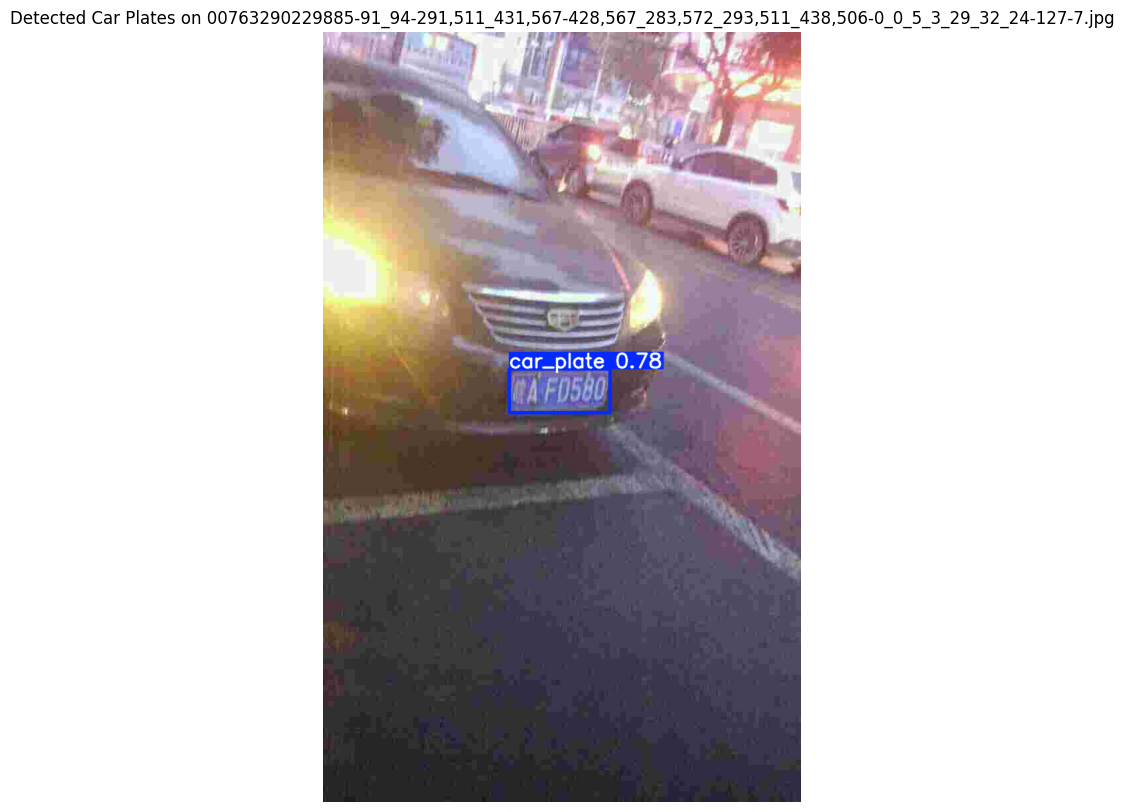

  Detections for 00763290229885-91_94-291,511_431,567-428,567_283,572_293,511_438,506-0_0_5_3_29_32_24-127-7.jpg:
    - car_plate, Confidence: 0.78, Box: [280, 507, 432, 573]

Processing image: 0180962643678-92_80-222,447_460,536-469,545_238,525_220,445_451,465-0_0_24_24_28_14_28-34-29.jpg

image 1/1 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/0180962643678-92_80-222,447_460,536-469,545_238,525_220,445_451,465-0_0_24_24_28_14_28-34-29.jpg: 640x416 1 car_plate, 10.2ms
Speed: 1.5ms preprocess, 10.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 416)


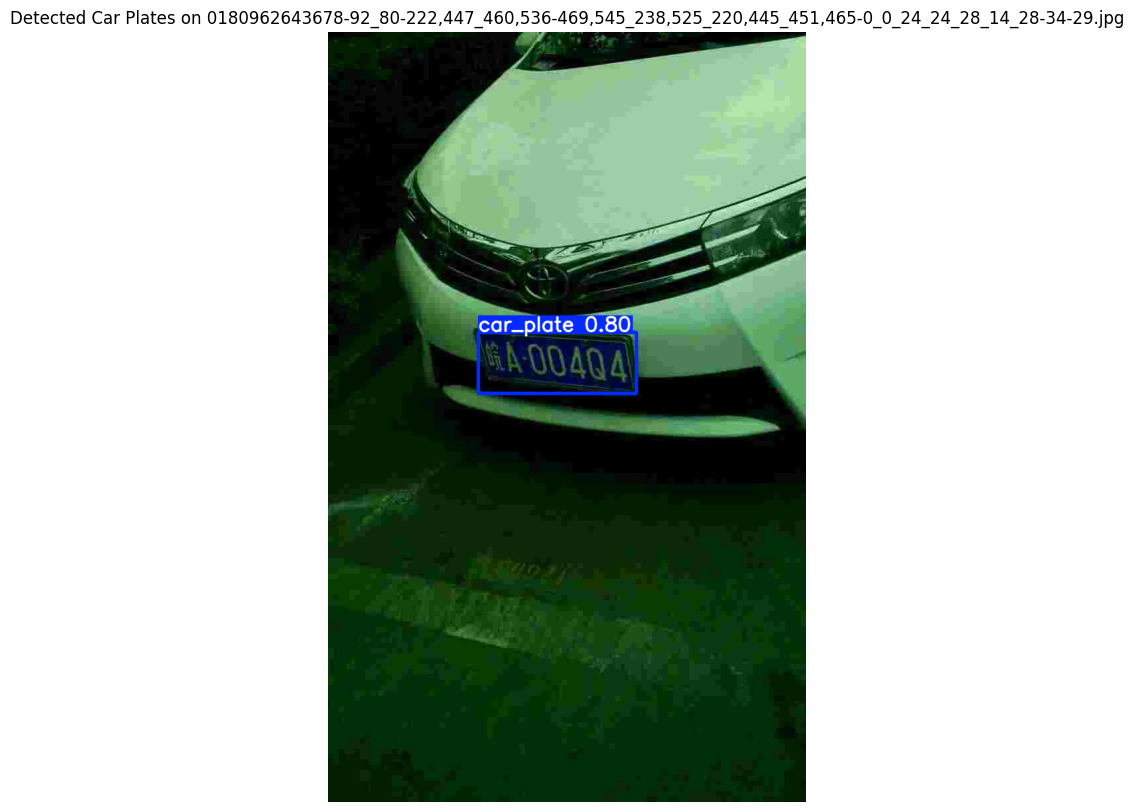

  Detections for 0180962643678-92_80-222,447_460,536-469,545_238,525_220,445_451,465-0_0_24_24_28_14_28-34-29.jpg:
    - car_plate, Confidence: 0.80, Box: [226, 452, 464, 544]

Processing image: 0169971264367-86_96-277,557_465,646-469,619_280,642_293,573_482,550-10_0_11_29_27_25_32-155-46.jpg

image 1/1 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/0169971264367-86_96-277,557_465,646-469,619_280,642_293,573_482,550-10_0_11_29_27_25_32-155-46.jpg: 640x416 1 car_plate, 8.6ms
Speed: 1.5ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 416)


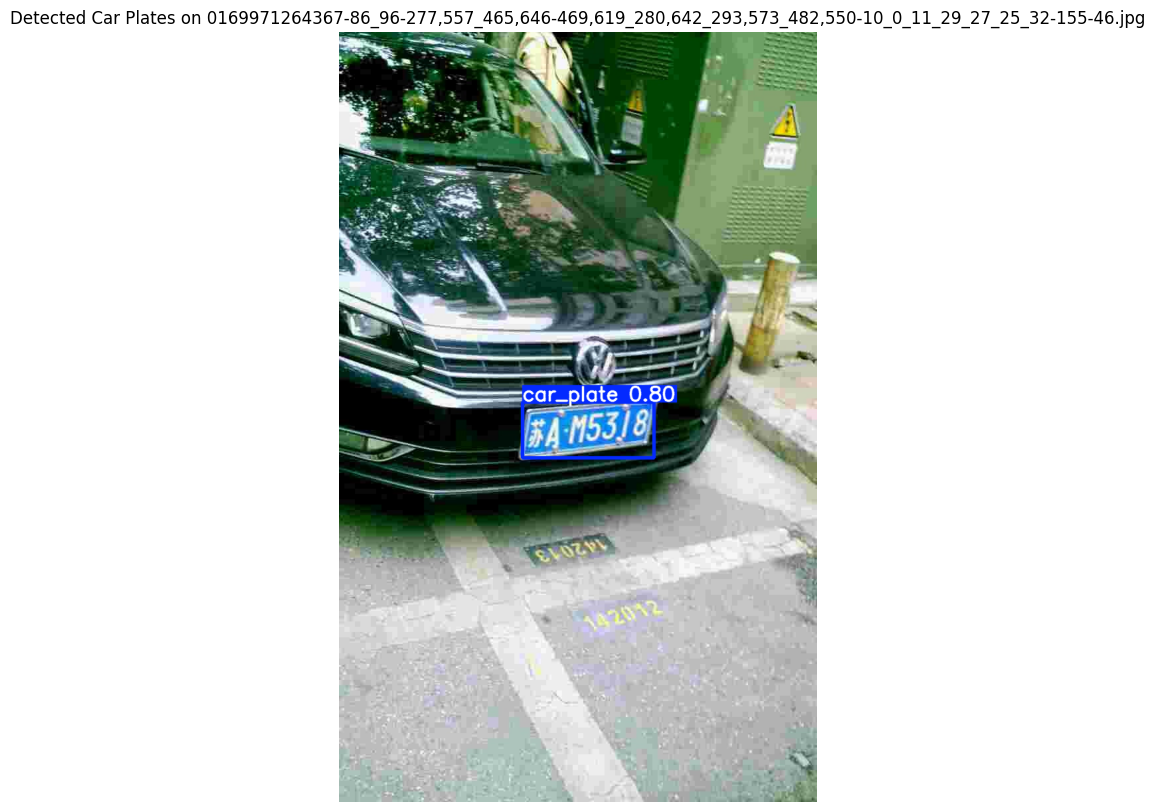

  Detections for 0169971264367-86_96-277,557_465,646-469,619_280,642_293,573_482,550-10_0_11_29_27_25_32-155-46.jpg:
    - car_plate, Confidence: 0.80, Box: [276, 557, 474, 641]
Visualization complete.

Script finished.


In [ ]:

#Here let's Visualize the Predicted Bounding Boxes on Test Images

print("\n--- Step 9: Visualizing Predicted Bounding Boxes ---")

test_images_dir = os.path.join(output_yolo_dir, 'images', 'test')

if not os.path.exists(test_images_dir):
    print(f"Error: Test images directory not found at {test_images_dir}.")
    print("Cannot perform visualization without test images.")
else:
    test_image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if not test_image_files:
        print(f"No image files found in {test_images_dir}. Cannot perform visualization.")
    else:
        num_images_to_visualize = 5
        selected_images = random.sample(test_image_files, min(num_images_to_visualize, len(test_image_files)))

        print(f"Visualizing detections on {len(selected_images)} random test images...")

        for img_filename in selected_images:
            img_path = os.path.join(test_images_dir, img_filename)

            print(f"\nProcessing image: {img_filename}")

            results = trained_model(img_path)

            for r in results:
                im_bgr = r.plot()
                im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

                plt.figure(figsize=(15, 10))
                plt.imshow(im_rgb)
                plt.axis('off')
                plt.title(f'Detected Car Plates on {img_filename}')
                plt.show()

                boxes = r.boxes.xyxy.cpu().numpy()
                scores = r.boxes.conf.cpu().numpy()
                class_ids = r.boxes.cls.cpu().numpy()

                if len(boxes) > 0:
                    print(f"  Detections for {img_filename}:")
                    for i, box in enumerate(boxes):
                        x1, y1, x2, y2 = map(int, box)
                        score = scores[i]
                        class_name = trained_model.names[int(class_ids[i])]
                        print(f"    - {class_name}, Confidence: {score:.2f}, Box: [{x1}, {y1}, {x2}, {y2}]")
                else:
                    print(f"  No car plates detected in {img_filename}.")
print("Visualization complete.")

print("\nScript finished.")